In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

pd.set_option('display.max_columns', 200)

path = "/content/ASA All PGA Raw Data - Tourn Level.csv"

df = pd.read_csv(path, low_memory=False)
print("Loaded dataset shape:", df.shape)
df.head()

Loaded dataset shape: (36864, 37)


,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,streak_SDP,n_rounds,made_cut,pos,finish_DKP,finish_FDP,finish_SDP,total_DKP,total_FDP,total_SDP,player,Unnamed: 2,Unnamed: 3,Unnamed: 4,tournament name,course,date,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,3,4,1,32.0,2,1,0,65.0,59.7,59,Abraham Ancer,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,3,4,1,18.0,5,4,2,85.5,78.5,66,Adam Hadwin,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,0,2,0,NaN,0,0,0,21.5,17.4,27,Anirban Lahiri,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,0,2,0,NaN,0,0,0,20.5,14.0,17,Adam Long,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,0,2,0,NaN,0,0,0,23.5,19.3,23,Alexander Noren,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


In [3]:
print("Columns:", len(df.columns))
print(df.columns.tolist()[:80])
print("\nTarget 'strokes' description:")
display(df['strokes'].describe())

print("\nMissingness (top):")
display(df.isna().sum().sort_values(ascending=False).head(40))

Columns: 37
['Player_initial_last', 'tournament id', 'player id', 'hole_par', 'strokes', 'hole_DKP', 'hole_FDP', 'hole_SDP', 'streak_DKP', 'streak_FDP', 'streak_SDP', 'n_rounds', 'made_cut', 'pos', 'finish_DKP', 'finish_FDP', 'finish_SDP', 'total_DKP', 'total_FDP', 'total_SDP', 'player', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'tournament name', 'course', 'date', 'purse', 'season', 'no_cut', 'Finish', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

Target 'strokes' description:


,strokes
count,36864.000000
mean,224.114502
std,66.789007
min,66.000000
25%,146.000000
50%,272.000000
75%,281.000000
max,325.000000



Missingness (top):


,0
Unnamed: 3,36864
Unnamed: 4,36864
Unnamed: 2,36864
pos,15547
sg_t2g,7684
sg_arg,7684
sg_putt,7684
sg_ott,7684
sg_app,7684
Finish,7683


In [4]:
TARGET = "strokes"

# Drop columns with >60% missing values
missing_pct = df.isna().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.6].index.tolist()
print("Dropping columns:", len(cols_to_drop))
df = df.drop(columns=cols_to_drop, errors='ignore')

# Detect date and player fields (if present)
date_col = next((c for c in df.columns if 'date' in c.lower() or 'year' in c.lower()), None)
player_col = next((c for c in df.columns if 'player' in c.lower() and 'id' in c.lower()), None)
print("Date col:", date_col, "Player id col:", player_col)

# Drop rows missing target
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

# If date present, convert and sort; else keep original order
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)

# Numeric candidate features (exclude ids + target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude = ['player id', 'tournament id', TARGET]
feature_cols = [c for c in numeric_cols if c not in exclude]

# Create lag features (player-based if possible)
if player_col and date_col:
    df = df.sort_values([player_col, date_col]).reset_index(drop=True)
    df['score_lag1'] = df.groupby(player_col)[TARGET].shift(1)
    df['score_lag2'] = df.groupby(player_col)[TARGET].shift(2)
    df['avg_last3'] = df.groupby(player_col)[TARGET].rolling(3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
else:
    df['score_lag1'] = df[TARGET].shift(1)
    df['score_lag2'] = df[TARGET].shift(2)
    df['avg_last3'] = df[TARGET].rolling(3, min_periods=1).mean().shift(1)

# Add lags to features
for f in ['score_lag1','score_lag2','avg_last3']:
    if f in df.columns and f not in feature_cols:
        feature_cols.append(f)

# Keep only numeric features that exist
feature_cols = [c for c in feature_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
print("Feature count:", len(feature_cols))


Dropping columns: 3
Date col: date Player id col: player id
Feature count: 28


In [5]:
# Fill numeric NaNs with median
for c in feature_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Train/test split - time-aware holdout (earliest 80% train, latest 20% test)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

X_train = train[feature_cols].astype(float); y_train = train[TARGET].astype(float)
X_test = test[feature_cols].astype(float); y_test = test[TARGET].astype(float)

print("Train/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (29491, 28) (7373, 28)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    res = {
        "train_mae": mean_absolute_error(y_tr, pred_tr),
        "test_mae": mean_absolute_error(y_te, pred_te),
        "train_rmse": mean_squared_error(y_tr, pred_tr) ** 0.5,
        "test_rmse": mean_squared_error(y_te, pred_te) ** 0.5,
        "train_r2": r2_score(y_tr, pred_tr),
        "test_r2": r2_score(y_te, pred_te),
    }
    return res, pred_te


In [11]:
# change n_estimators to control runtime
lr = LinearRegression()
lr_res, lr_pred = eval_model(lr, X_train, y_train, X_test, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_res, rf_pred = eval_model(rf, X_train, y_train, X_test, y_test)

xgb = XGBRegressor(n_estimators=150, random_state=42, verbosity=0, use_label_encoder=False)
xgb_res, xgb_pred = eval_model(xgb, X_train, y_train, X_test, y_test)

metrics = pd.DataFrame([{"model":"LinearRegression", **lr_res},
                        {"model":"RandomForest", **rf_res},
                        {"model":"XGBoost", **xgb_res}])
display(metrics)
metrics.to_csv("model_metrics.csv", index=False)


,model,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2
0,LinearRegression,0.330915,0.326440,0.494779,0.496385,0.999945,0.999944
1,RandomForest,0.127937,0.355646,0.223250,0.608105,0.999989,0.999916
2,XGBoost,0.225451,0.359356,0.321098,0.563415,0.999977,0.999928


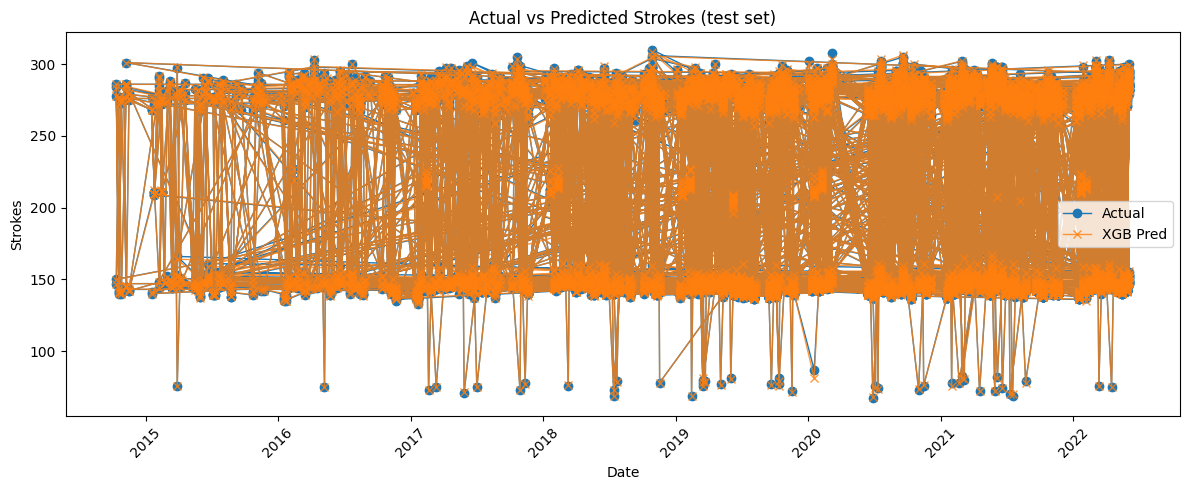

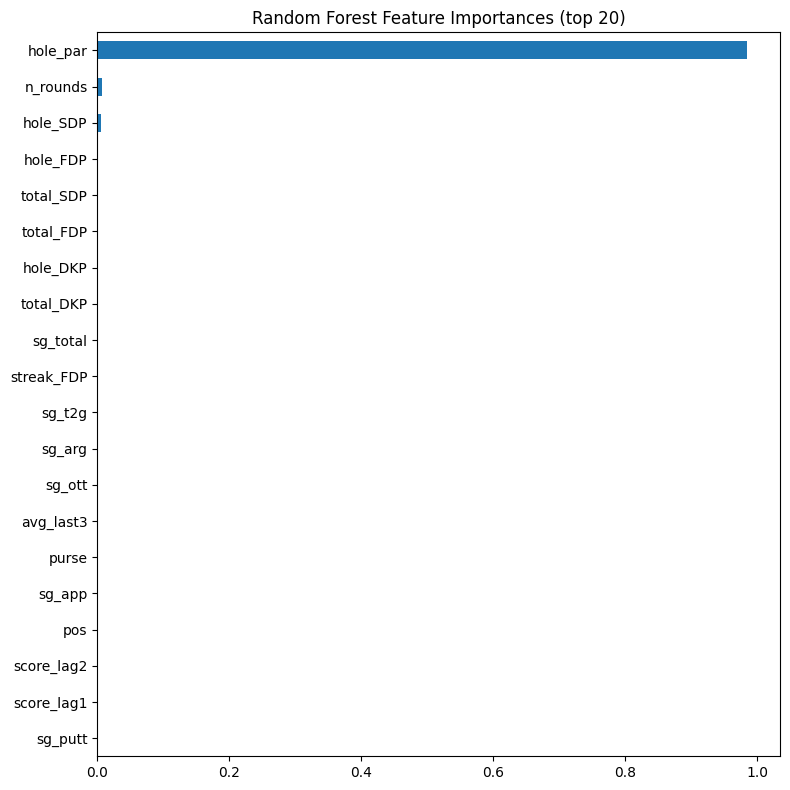

,0
hole_par,0.985458
n_rounds,0.007077
hole_SDP,0.006426
hole_FDP,0.000619
total_SDP,0.000304
total_FDP,0.000030
hole_DKP,0.000021
total_DKP,0.000008
sg_total,0.000007
streak_FDP,0.000005


In [12]:
# Actual vs Predicted (XGB)
plt.figure(figsize=(12,5))
x_axis = test[date_col] if date_col and date_col in test.columns and not test[date_col].isna().all() else range(len(test))
plt.plot(x_axis, y_test.values, label='Actual', marker='o', linewidth=1)
plt.plot(x_axis, xgb_pred, label='XGB Pred', marker='x', linewidth=1, alpha=0.8)
plt.legend(); plt.title('Actual vs Predicted Strokes (test set)'); plt.xlabel('Date' if date_col else 'Index'); plt.ylabel('Strokes')
plt.xticks(rotation=45); plt.tight_layout(); plt.savefig("figure_actual_vs_pred.png", dpi=150); plt.show()

# RF feature importances
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,8)); importances.head(20).plot(kind='barh'); plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (top 20)"); plt.tight_layout(); plt.savefig("figure_feature_importance.png", dpi=150); plt.show()
display(importances.head(20))


PermutationExplainer explainer: 201it [01:04,  3.00it/s]
/tmp/ipython-input-1668812160.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_shap, show=False)


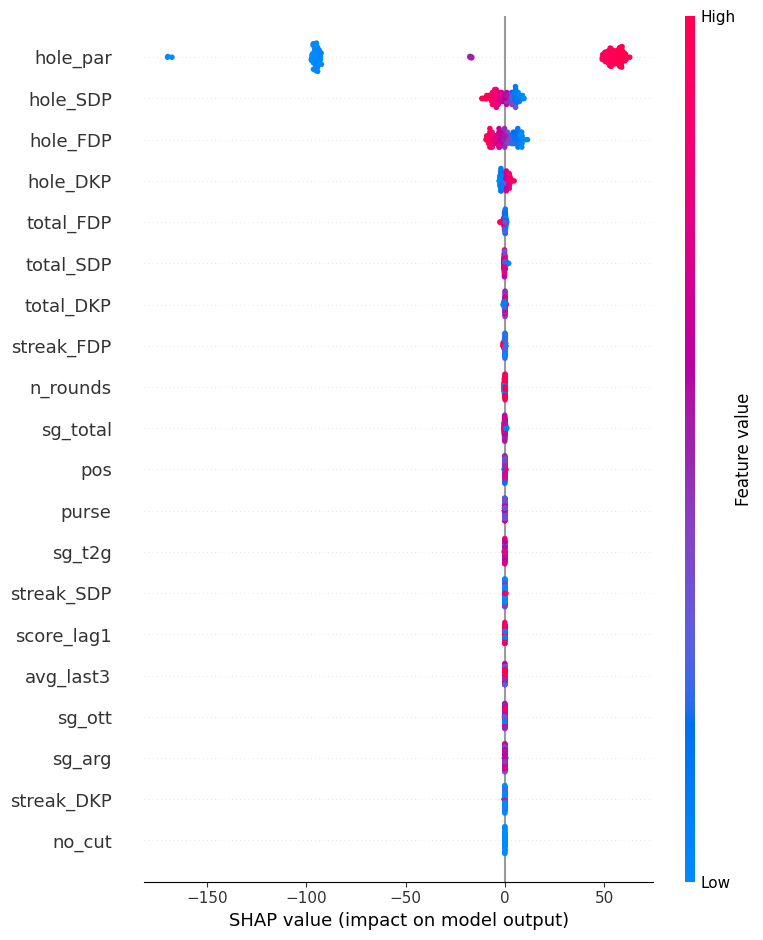

In [24]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# sample subset
sample_n = min(200, len(X_test))
idx = np.random.choice(range(len(X_test)), size=sample_n, replace=False)
X_shap = X_test.iloc[idx]

# Use KernelExplainer
explainer = shap.Explainer(xgb.predict, X_shap)
shap_values = explainer(X_shap)

# plot
shap.summary_plot(shap_values.values, X_shap, show=False)
plt.tight_layout()
plt.savefig("figure_shap_summary.png", dpi=150)
plt.show()



In [21]:
!pip install shap==<desired_shap_version> xgboost==<desired_xgboost_version>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install shap==<desired_shap_version> xgboost==<desired_xgboost_version>'


In [25]:
joblib.dump(xgb, "xgb_strokes_model.joblib")
test_results = test[[TARGET]].copy()
test_results['xgb_pred'] = xgb_pred
test_results['rf_pred'] = rf_pred
test_results['lr_pred'] = lr_pred
test_results.to_csv("golf_model_test_results.csv", index=False)
print("Saved model, metrics, figures and test results in /content/")


Saved model, metrics, figures and test results in /content/
